# Bibliotecas

In [2]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

In [4]:
from tqdm.notebook import tqdm

In [5]:
sns.set_theme()

In [6]:
RANDOM_SEED = 33
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Download CIC IDS 2017

[Este](https://www.unb.ca/cic/datasets/ids-2017.html) conjunto de dados contém informações sobre fluxos de rede, representando tanto o tráfego benigno quanto ataques populares. Para o ambiente de teste desta coleta de dados, uma rede foi configurada para o atacante e uma rede separada foi configurada para as vítimas, esta última contendo firewalls, roteadores, switches, servidores e estações de trabalho em execução em diferentes versões dos sistemas operacionais Windows e Linux. Para gerar o tráfego benigno, os autores utilizaram um sistema desenvolvido por eles mesmos, que então extraiu o comportamento abstrato de 25 usuários com base em diferentes protocolos de aplicação. Os dados foram coletados ao longo de cinco dias de atividade de rede e foram processados para extrair mais de 80 features do conjunto de dados usando a ferramenta CICFlowMeter8.


In [ ]:
# update gdown version
!pip install --upgrade --no-cache-dir gdown

In [ ]:
# !wget http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/MachineLearningCSV.zip -O CIC_IDS_2017.zip
!gdown '1WtbUHBpANHLMVVHuaFr9-pGUyeW6QhdD' -O CIC_IDS_2017.zip

In [ ]:
# !unzip MachineLearningCSV.zip
!unzip ./CIC_IDS_2017.zip

# Carregando os dados

In [10]:
df_list = []
for file in os.listdir('../../../Dados/MachineLearningCVE/'):
  df_aux = pd.read_csv(f'../../../Dados/MachineLearningCVE/{file}')
  df_list.append(df_aux)
df = pd.concat(df_list, ignore_index=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [12]:
list(df.columns)[:6]

[' Destination Port',
 ' Flow Duration',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 'Total Length of Fwd Packets',
 ' Total Length of Bwd Packets']

Algumas colunas tem seus nomes iniciados com espaços ou finalizados com espaços. Vamos remover esses espaços não úteis para ajustar o nome das colunas.

In [13]:
df.columns = df.columns.str.strip()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  

# Limpando os dados

É necessário limpar os dados realizando:
- Descarte de registros duplicados
- Descarte de registros com valores NaN (Not a Number)/ Null / NA (Not Available)
- Evitar registros com valores não finitos. Nesse caso, uma abordagem válida é substituirmos os mesmos pelo maior valor finito presente no dataset.

Registros duplicados

In [15]:
df[df.duplicated()]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
2109,80,77,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2257,443,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2749,443,49,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2862,443,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2877,443,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830701,53,179,2,2,46,46,23,23,23.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830725,53,161,2,2,82,114,41,41,41.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830726,53,212,2,2,84,162,42,42,42.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830731,443,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [16]:
# Descartando duplicadas
initial_len = df.shape[0]
df = df.drop_duplicates()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartadas {initial_len - df.shape[0]} duplicadas')

Tamanho inicial: 2830743, tamanho final 2522362 | Descartadas 308381 duplicadas


Registros com valores Null/NaN/NA

In [17]:
df.columns[df.isna().any(axis=0)]

Index(['Flow Bytes/s'], dtype='object')

In [18]:
df[df.isna().any(axis=1)][['Flow Bytes/s']]

,Flow Bytes/s
6796,NaN
14739,NaN
15047,NaN
209728,NaN
238569,NaN
...,...
2740049,NaN
2767532,NaN
2791593,NaN
2809052,NaN


In [19]:
# Descartando registros com valores NaN/Null/NA
initial_len = df.shape[0]
df = df.dropna()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartados {initial_len - df.shape[0]} registros com valores NA')

Tamanho inicial: 2522362, tamanho final 2522009 | Descartados 353 registros com valores NA


In [20]:
df = df.reset_index(drop=True)

Registros com valores não finitos

In [21]:
df_columns_isfinite = np.isfinite(df.drop(['Label'], axis='columns')).all(axis=0)
df_columns_isfinite[df_columns_isfinite == False]

Flow Bytes/s      False
Flow Packets/s    False
dtype: bool

In [22]:
df_rows_isfinite = np.isfinite(df.drop(['Label'], axis='columns')).all(axis=1)
inf_indexes = df_rows_isfinite[df_rows_isfinite == False].index
df.iloc[inf_indexes][['Flow Bytes/s', 'Flow Packets/s', 'Flow Duration']]

,Flow Bytes/s,Flow Packets/s,Flow Duration
65,inf,inf,0
1767,inf,inf,0
1890,inf,inf,0
3365,inf,inf,0
8001,inf,inf,0
...,...,...,...
2515309,inf,inf,0
2515565,inf,inf,0
2516784,inf,inf,0
2516908,inf,inf,0


In [23]:
# Evitando registros com valores não finitos
max_finite_flow_packets_per_sec = df[np.isfinite(df['Flow Packets/s'])]['Flow Packets/s'].max()
max_finite_flow_bytes_per_sec = df[np.isfinite(df['Flow Bytes/s'])]['Flow Bytes/s'].max()

df.loc[df['Flow Packets/s'] == np.inf, 'Flow Packets/s'] = max_finite_flow_packets_per_sec
df.loc[df['Flow Bytes/s'] == np.inf, 'Flow Bytes/s'] = max_finite_flow_bytes_per_sec

# Mini análise exploratória

### Quantidade de instâncias benignas x maliciosas

<Axes: xlabel='Label', ylabel='count'>

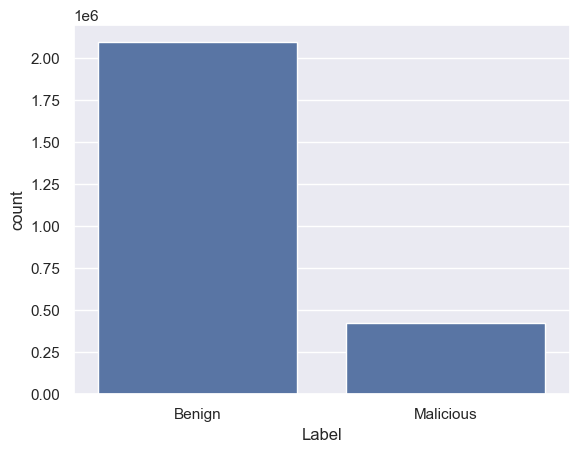

In [24]:
sns.countplot(data=df['Label'].apply(lambda label: 'Malicious' if label != 'BENIGN' else 'Benign').to_frame(), x='Label')

**Dados não balanceados**. Impactos:
- Dificuldade de treinar modelos supervisionados
- Dificuldade de avaliar resultados com métricas tradicionais como acurácia

### Quantidade de instâncias por tipo de ataque

Abaixo está um descritivo para os ataques do dataset:

**DoS (Denial of Service)**: Esses ataques, como "DoS Hulk", "DoS GoldenEye", "DoS Slowloris", "DoS Slowhttptest" e "DDoS" visam tornar temporariamente uma máquina ou recurso de rede indisponível, sendo diferenciados pelo protocolo e estratégia usados para causar a negação de serviço. No caso do "DDoS", várias máquinas Windows 8.1 foram usadas para enviar solicitações UDP, TCP e HTTP.

**FTP Patator" e "SSH Patator**: Usam o software Patator para adivinhar senhas por força bruta com o uso de listas de palavras.

**Web - Brute Force**: Usa força bruta em uma aplicação com listas de palavras.

**Web - Injeção de SQL**: Esse ataque explora vulnerabilidades em máquinas conectadas publicamente à Internet usando injeção SQL.

**Web - XSS (Cross-Site Scripting)**: Representa injeções de scripts em aplicativos da web, visando a execução de ações maliciosas por outros usuários do aplicativo.

**PortScan**: Realizados com a ferramenta NMap, esses ataques buscam informações sobre os serviços e portas abertas em um alvo.

**Bot**: Esse ataque tem várias possibilidades, como roubo de dados, envio de spam e acesso ao dispositivo. .

**Infiltration**: Baseado na infecção de uma máquina após um usuário abrir um arquivo malicioso.

In [25]:
df['Label'] = df['Label'].replace({'Web Attack � Brute Force':'Brute Force', 'Web Attack � XSS':'XSS', 'Web Attack � Sql Injection':'Sql Injection'})

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'DoS Hulk'),
  Text(1, 0, 'DDoS'),
  Text(2, 0, 'PortScan'),
  Text(3, 0, 'DoS GoldenEye'),
  Text(4, 0, 'FTP-Patator'),
  Text(5, 0, 'DoS slowloris'),
  Text(6, 0, 'DoS Slowhttptest'),
  Text(7, 0, 'SSH-Patator'),
  Text(8, 0, 'Bot'),
  Text(9, 0, 'Brute Force'),
  Text(10, 0, 'XSS'),
  Text(11, 0, 'Infiltration'),
  Text(12, 0, 'Sql Injection'),
  Text(13, 0, 'Heartbleed')])

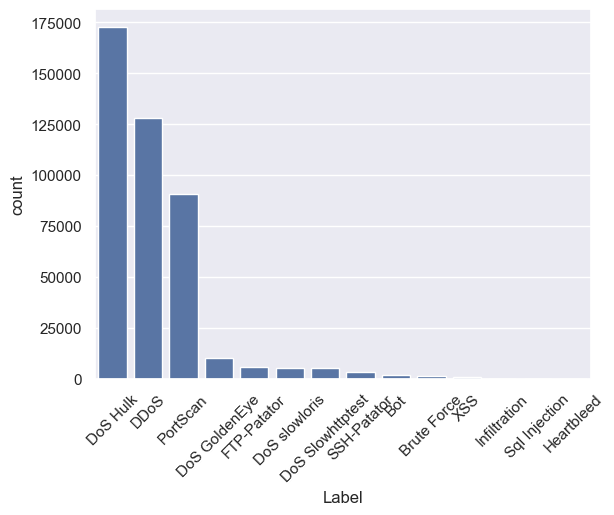

In [26]:
sns.countplot(data=df.query('Label != "BENIGN"')[['Label']], x='Label', order = df.query('Label != "BENIGN"')['Label'].value_counts().index)
plt.xticks(rotation=45)

Ataques menos representados

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Infiltration'),
  Text(1, 0, 'Brute Force'),
  Text(2, 0, 'XSS'),
  Text(3, 0, 'Sql Injection'),
  Text(4, 0, 'Heartbleed')])

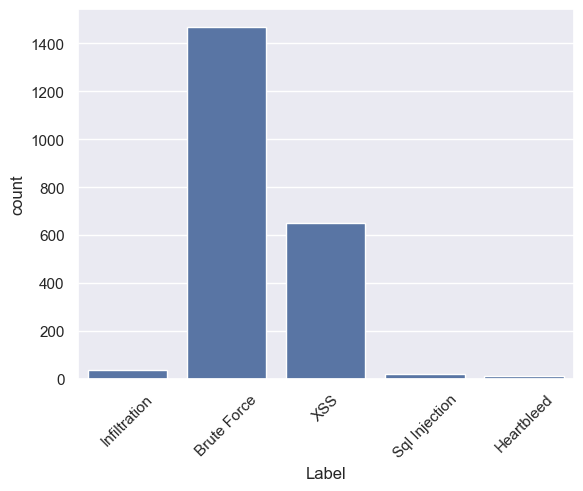

In [27]:
N_LESS_REPRESENTED_LABELS = 5

sns.countplot(data=df[df['Label'].isin(df.groupby('Label').size().sort_values(ascending=False)[(-1)*N_LESS_REPRESENTED_LABELS:].index)], x='Label')
plt.xticks(rotation=45)

### Estatísticas dos dados

In [28]:
interesting_cols = ['Flow Duration', 'Flow Bytes/s', 'Total Fwd Packets', 'Average Packet Size', 'SYN Flag Count']
df[interesting_cols].describe()

,Flow Duration,Flow Bytes/s,Total Fwd Packets,Average Packet Size,SYN Flag Count
count,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06
mean,1.658364e+07,2.404467e+06,1.027750e+01,2.123412e+02,4.874487e-02
std,3.522618e+07,5.254864e+07,7.942294e+02,3.454504e+02,2.153342e-01
min,-1.300000e+01,-2.610000e+08,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.080000e+02,1.194510e+02,2.000000e+00,9.000000e+00,0.000000e+00
50%,5.058700e+04,3.722028e+03,2.000000e+00,8.075000e+01,0.000000e+00
75%,5.330376e+06,1.079162e+05,6.000000e+00,1.796923e+02,0.000000e+00
max,1.200000e+08,2.071000e+09,2.197590e+05,3.893333e+03,1.000000e+00


# Dividindo dados nos conjuntos de treino, validação e teste

**Conjunto de treino**

Para a detecção de anomalias, vamos usar somente os dados que representam o tráfego benigno para o conjunto de treino. Dessa forma, os algoritmos de clustering vão ser capazes de identificar padrões e desvios em relação ao comportamento normal (benigno) dos dados.

**Conjuntos de validação e teste**

Porém, devem ser incluídos dados que representam o tráfego maliciosos nos conjuntos de validação e teste. Esses dados maliciosos no conjunto de validação são importantes para que possamos definir um *threshold* para que seja possível detectar anomalias. Além disso, os dados maliciosos também precisam ser incluídos no conjunto de teste para que possamos avaliar o desempenho do nosso modelo.

In [29]:
df_train = df.query('Label == "BENIGN"').sample(frac=0.6, random_state=RANDOM_SEED)
df_val_test = df.drop(df_train.index)

df_train = df_train.reset_index(drop=True)
df_val_test = df_val_test.reset_index(drop=True)

X_train = df_train.drop('Label', axis='columns')

In [30]:
X_val, X_test, classes_val, classes_test = train_test_split(df_val_test.drop('Label', axis='columns'), df_val_test['Label'], test_size=0.65, stratify=df_val_test['Label'], random_state=RANDOM_SEED)

X_val, X_test = X_val.reset_index(drop=True), X_test.reset_index(drop=True)
classes_val, classes_test =  classes_val.reset_index(drop=True), classes_test.reset_index(drop=True)

y_val, y_test = classes_val.apply(lambda c: 0 if c == 'BENIGN' else 1), classes_test.apply(lambda c: 0 if c == 'BENIGN' else 1)

In [31]:
del df_train, df_val_test

# Analisando correlação entre features

**Por que remover features?**

Vamos descartar features com alta correlação evitando passar informações redundantes ao modelo. Dessa forma, conseguiremos obter um modelo mais simples e com menor custo computacional.

In [32]:
def get_highly_correlated_features(correlation_matrix, threshold):
  correlated_pairs = []
  for i in range(len(correlation_matrix.columns)):
    for j in range(i):
      if abs(correlation_matrix.iloc[i, j]) > threshold:
        pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
        coefficient = correlation_matrix.iloc[i, j]
        correlated_pairs.append((pair, coefficient))
  return sorted(correlated_pairs, key= lambda pair: pair[1], reverse=True)


In [33]:
corr_matrix = X_train.corr().abs()
correlation_list = get_highly_correlated_features(corr_matrix, 0.95)

In [34]:
correlation_list[:10]

[(('Avg Bwd Segment Size', 'Bwd Packet Length Mean'), 1.0000000000000002),
 (('SYN Flag Count', 'Fwd PSH Flags'), 1.0),
 (('CWE Flag Count', 'Fwd URG Flags'), 1.0),
 (('Avg Fwd Segment Size', 'Fwd Packet Length Mean'), 1.0),
 (('Fwd Header Length.1', 'Fwd Header Length'), 1.0),
 (('Subflow Fwd Packets', 'Total Fwd Packets'), 1.0),
 (('Subflow Fwd Bytes', 'Total Length of Fwd Packets'), 1.0),
 (('Subflow Bwd Packets', 'Total Backward Packets'), 1.0),
 (('Subflow Bwd Bytes', 'Total Length of Bwd Packets'), 0.9999998619402976),
 (('Subflow Fwd Packets', 'Total Backward Packets'), 0.9991954734499192)]

In [35]:
# Drop high correlated features in correlation list

f2drop = []
for feature_pair, _ in correlation_list:
  if feature_pair[0] not in f2drop and feature_pair[1] not in f2drop:
    f2drop.append(feature_pair[1])

In [36]:
f2drop

['Bwd Packet Length Mean',
 'Fwd PSH Flags',
 'Fwd URG Flags',
 'Fwd Packet Length Mean',
 'Fwd Header Length',
 'Total Fwd Packets',
 'Total Length of Fwd Packets',
 'Total Backward Packets',
 'Total Length of Bwd Packets',
 'Subflow Fwd Packets',
 'Flow Duration',
 'RST Flag Count',
 'Subflow Bwd Packets',
 'Packet Length Mean',
 'Flow IAT Max',
 'Idle Mean',
 'Fwd IAT Total',
 'Fwd Packet Length Max',
 'Max Packet Length',
 'Bwd IAT Max',
 'Bwd IAT Mean',
 'Fwd IAT Max',
 'Fwd IAT Mean',
 'Idle Max']

A feature "Destination Port", também não fornece muita contribuição devido que a mesma está codificada com valores inteiros, indicando uma relação de grandeza, como 44720 > 80, que não apresenta sentido semântico quando se trata da porta de destino de um fluxo de rede.

In [37]:
f2drop = f2drop + ['Destination Port']

In [38]:
X_train = X_train.drop(f2drop, axis='columns')
X_val = X_val.drop(f2drop, axis='columns')
X_test = X_test.drop(f2drop, axis='columns')

# Normalizando os dados

É importante normalizar os dados para lidar com diferentes escalas, sensibilidades a escalas e até mesmo melhorar o desempenho da convergência dos algoritmos.

Caso não seja realizada a normalização, um valor de 10000 para uma feature como "Flow Bytes/s" terá impacto similar ao modelo quanto um valor de 10000 para uma feature como "Flow Packets/s". Isso é prejudicial, pois o impacto desse valor para as duas features deve ser tratado de forma distinta, já que as mesmas têm escalas e sensibilidades também distintas.

In [39]:
minmax_scaler = MinMaxScaler()
minmax_scaler = minmax_scaler.fit(X_train)

norm_X_train = minmax_scaler.transform(X_train)
norm_X_val = minmax_scaler.transform(X_val)
norm_X_test = minmax_scaler.transform(X_test)

In [40]:
del X_train, X_val, X_test

# Detecção de Anomalias com Autoencoders

## Autoencoder - Explicação

<div align="center">

![Autoencoder](https://tikz.net/janosh/autoencoder.png)
</div>

Um autoencoder é uma arquitetura de rede neural que aprende a codificar dados em uma representação compacta, chamada de espaço latente, e então reconstruir os dados a partir dessa representação. Ele consiste em duas partes principais: o encoder, que mapeia os dados de entrada para o espaço latente, e o decoder, que reconstrói os dados a partir dessa representação. A ideia central é forçar o modelo a aprender uma representação eficiente e informativa dos dados de entrada.

Os autoencoders são frequentemente usados para tarefas de redução de dimensionalidade e denoising. No entanto, eles também são aplicáveis à detecção de anomalias. A lógica é que um autoencoder treinado em dados normais aprenderá a representação latente desses dados, e quando apresentado com dados anômalos que diferem significativamente dos dados normais, a reconstrução será prejudicada, levando a um erro de reconstrução maior.

## Relembrando o processo de treinamento de redes neurais - Backpropagation

<div align="center">

![Backpropagation](https://miro.medium.com/v2/resize:fit:640/format:webp/1*VF9xl3cZr2_qyoLfDJajZw.gif)
</div>

## Mecanismo de Early Stopping


<div align="center">

![Early stopping](https://www.researchgate.net/publication/356747729/figure/fig3/AS:1098404738408449@1638891505126/Early-stopping-training-is-stopped-as-soon-as-the-performance-on-the-validation-loss.jpg)
</div>

O mecanismo de Early Stopping é uma técnica usada durante o treinamento de redes neurais para evitar overfitting e melhorar a eficiência do modelo. O objetivo é interromper o treinamento assim que a performance do modelo em um conjunto de validação começa a piorar, em vez de continuar até que o desempenho no conjunto de treinamento seja perfeito.

O mesmo inclui usa dos seguintes argumentos para definir um critério de parada:
- **paciência**: Quantidade de épocas limite para esperar melhoria na loss de validação
- **delta**: Melhoria mínina necessária para atualizar uma loss de validação

In [41]:
# Implementação do Early Stopping
class EarlyStopping:
  def __init__(self, patience=7, delta=0, verbose=True, path='checkpoint.pt'):
      self.patience = patience
      self.delta = delta
      self.verbose = verbose
      self.counter = 0
      self.early_stop = False
      self.val_min_loss = np.Inf
      self.path = path

  def __call__(self, val_loss, model):
    if val_loss < self.val_min_loss - self.delta:   # Caso a loss da validação reduza, vamos salvar o modelo e nova loss mínima
      self.save_checkpoint(val_loss, model)
      self.counter = 0
    else:                                           # Caso a loss da validação NÃO reduza, vamos incrementar o contador da paciencia
      self.counter += 1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}. Current validation loss: {val_loss:.5f}')
      if self.counter >= self.patience:
          self.early_stop = True

  def save_checkpoint(self, val_loss, model):
    if self.verbose:
        print(f'Validation loss decreased ({self.val_min_loss:.5f} --> {val_loss:.5f}).  Saving model ...')
    torch.save(model, self.path)
    self.val_min_loss = val_loss

## Autoencoder - Implementação

In [42]:
# Implementação do Autoencoder
class Autoencoder(nn.Module):
  def __init__(self, in_features, dropout_rate=0.2, num_layers=6, init_layer_size=30, mod_en_layer_size=10, mltpli_f=False):
    super().__init__()

    self.in_features = in_features
    self.dropout_rate = dropout_rate
    self.early_stopping = None
    self.num_layers = num_layers
    self.init_layer_size = init_layer_size
    self.mltpli_f = mltpli_f

    encoder_layers = [] # Lista para armazenar as camadas do encoder

    # Adiciona camadas ao encoder
    for i in range(num_layers//2):
        if i == 0:
            encoder_layers.append(nn.Linear(in_features, init_layer_size))
            layer_size = init_layer_size
            encoder_layers.append(nn.BatchNorm1d(layer_size))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(dropout_rate))
        elif i == (num_layers//2 - 1):
            if mltpli_f == True:
                encoder_layers.append(nn.Linear(layer_size, int(layer_size*mod_en_layer_size)))
                final_en_layer_size = int(layer_size*mod_en_layer_size)
            elif mltpli_f == False:
                encoder_layers.append(nn.Linear(layer_size, int(layer_size-mod_en_layer_size)))
                final_en_layer_size = int(layer_size-mod_en_layer_size)
            encoder_layers.append(nn.BatchNorm1d(final_en_layer_size))
            encoder_layers.append(nn.ReLU())
        else:
            if mltpli_f == True:
                encoder_layers.append(nn.Linear(layer_size, int(layer_size*mod_en_layer_size)))
                layer_size = int(layer_size*mod_en_layer_size)
            elif mltpli_f == False:
                encoder_layers.append(nn.Linear(layer_size, int(layer_size-mod_en_layer_size)))
                layer_size = int(layer_size-mod_en_layer_size)
            encoder_layers.append(nn.BatchNorm1d(layer_size))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(dropout_rate))

    self.encoder = nn.Sequential(*encoder_layers) # Define o encoder como uma sequência

    
    decoder_layers = [] # Lista para armazenar as camadas do decoder

    if mltpli_f == True:
        mod_de_layer_size = 1/mod_en_layer_size # Inverte o multiplicador
    elif mltpli_f == False:
        mod_de_layer_size = -(mod_en_layer_size)

    # Adiciona camadas ao decoder
    for i in range(num_layers//2):
        if i == 0:
            if mltpli_f == True:
                decoder_layers.append(nn.Linear(final_en_layer_size, math.ceil(int(final_en_layer_size*mod_de_layer_size))))
                layer_size = math.ceil(int(final_en_layer_size*mod_de_layer_size))
            elif mltpli_f == False:
                decoder_layers.append(nn.Linear(final_en_layer_size, math.ceil(int(final_en_layer_size-mod_de_layer_size))))
                layer_size = math.ceil(int(final_en_layer_size-mod_de_layer_size))
            decoder_layers.append(nn.BatchNorm1d(layer_size))  
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Dropout(dropout_rate))
        elif i == (num_layers//2 - 1):
            decoder_layers.append(nn.Linear(layer_size, in_features)) 
            decoder_layers.append(nn.BatchNorm1d(in_features))  
            decoder_layers.append(nn.Sigmoid())
        else:
            if mltpli_f == True:
                decoder_layers.append(nn.Linear(layer_size, math.ceil(int(layer_size*mod_de_layer_size))))
                layer_size = math.ceil(int(layer_size*mod_de_layer_size))
            elif mltpli_f == False:
                decoder_layers.append(nn.Linear(layer_size, math.ceil(int(layer_size-mod_de_layer_size))))
                layer_size = math.ceil(int(layer_size-mod_de_layer_size))
            decoder_layers.append(nn.BatchNorm1d(layer_size))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Dropout(dropout_rate))


    # Define o decoder como uma sequência
    self.decoder = nn.Sequential(*decoder_layers)

    print(self.encoder)
    print(self.decoder)

  def forward(self, X):
    encoded = self.encoder(X)
    decoded = self.decoder(encoded)
    return decoded

  def compile(self, learning_rate):
    self.criterion = nn.MSELoss()
    self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)

  def fit(self, X_train, num_epochs, batch_size, X_val = None, patience = None, delta = None):
    if X_val is not None and patience is not None and delta is not None:
      print(f'Using early stopping with patience={patience} and delta={delta}')
      self.early_stopping = EarlyStopping(patience, delta)

    val_avg_losses = []
    train_avg_losses = []

    for epoch in range(num_epochs):
      # Calibrando os pesos do modelo
      train_losses = []
      self.train()
      for batch in tqdm(range(0, len(X_train), batch_size)):
        batch_X = X_train[batch:(batch+batch_size)]
        batch_reconstruction = self.forward(batch_X)

        train_loss = self.criterion(batch_reconstruction, batch_X)
        self.optimizer.zero_grad()
        train_loss.backward()
        self.optimizer.step()
        train_losses.append(train_loss.item())
      train_avg_loss = np.mean(train_losses)
      train_avg_losses.append(train_avg_loss)
      print(f'Epoch#{epoch+1}: Train Average Loss = {train_avg_loss:.5f}')

      # Mecanismo de early stopping
      if self.early_stopping is not None:
        val_losses = []
        self.eval()
        with torch.no_grad():
          for batch in range(0, len(X_val), batch_size):
            batch_X = X_val[batch:(batch+batch_size)]
            batch_reconstruction = self.forward(batch_X)
            val_loss = self.criterion(batch_reconstruction, batch_X)
            val_losses.append(val_loss.item())
        val_avg_loss = np.mean(val_losses)
        val_avg_losses.append(val_avg_loss)
        self.early_stopping(val_avg_loss, self)
        if self.early_stopping.early_stop:
          print(f'Stopped by early stopping at epoch {epoch+1}')
          break

    if self.early_stopping is not None:
      self = torch.load('checkpoint.pt')
    self.eval()
    return train_avg_losses, val_avg_losses

In [43]:
BATCH_SIZE = 256
LR = 5e-4
PATIENCE = 2
DELTA = 0.001
NUM_EPOCHS = 3
IN_FEATURES = norm_X_train.shape[1]
DROPOUT_RATE = 0.2
NUM_LAYERS = 6 # Digite um número par, se for ímpar será truncado para baixo. Será simétrico, ou seja, metade pro encoder e metade pro decoder. OBSERVAÇÃO: A camada "do meio"(a que separa o encoder do decoder) conta duas vezes
INITIAL_LAYER_SIZE = 30 # Tamanho da primeira camada do encoder(não conta com a camada de entrada)
MULTIPLIER_FLAG = False # Flag para dizer se o MOD_ENCODE_LAYER_SIZE será um multiplicador ou um valor para subtrair, no caso do encoder
MOD_ENCODE_LAYER_SIZE = 10 # Número usado para diminuir e aumentar a quantidade de camadas a partir do INITIAL_LAYER_SIZE, lembrando, o tamanho das camadas sempre tem que ser um inteiro, então, valores quebrados no encoder são truncados pra baixo, e no decoder são truncados pra cima(ceil). Exemplo: Se o valor for 0.5 e for um multiplicador, o encoder vai diminuir a quantidade de neurônios pela metade em cada camada do encoder, e vai dobrar em cada camada do decoder

In [44]:
ae_model = Autoencoder(IN_FEATURES, DROPOUT_RATE, NUM_LAYERS, INITIAL_LAYER_SIZE, MOD_ENCODE_LAYER_SIZE, MULTIPLIER_FLAG)
ae_model.compile(learning_rate = LR)

Sequential(
  (0): Linear(in_features=53, out_features=30, bias=True)
  (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=30, out_features=20, bias=True)
  (5): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=20, out_features=10, bias=True)
  (9): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
)
Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=20, out_features=30, bias=True)
  (5): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=30, 

In [45]:
from torchsummary import summary
summary(ae_model, (IN_FEATURES,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]           1,620
       BatchNorm1d-2                   [-1, 30]              60
              ReLU-3                   [-1, 30]               0
           Dropout-4                   [-1, 30]               0
            Linear-5                   [-1, 20]             620
       BatchNorm1d-6                   [-1, 20]              40
              ReLU-7                   [-1, 20]               0
           Dropout-8                   [-1, 20]               0
            Linear-9                   [-1, 10]             210
      BatchNorm1d-10                   [-1, 10]              20
             ReLU-11                   [-1, 10]               0
           Linear-12                   [-1, 20]             220
      BatchNorm1d-13                   [-1, 20]              40
             ReLU-14                   

In [46]:
# Exemplo de treinamento sem utilizar Early Stopping

train_avg_losses, _ = ae_model.fit(torch.FloatTensor(norm_X_train), NUM_EPOCHS, BATCH_SIZE)

  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.07993


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.01177


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.00369


In [47]:
# Exemplo de treinamento utilizando Early Stopping

# Passo 1: Considerar apenas amostras benignas no conjunto de validação
benign_norm_X_val = norm_X_val[y_val == 1]
benign_norm_X_val = torch.FloatTensor(benign_norm_X_val)

# Passo 2: Realizar treinamento do modelo
NUM_EPOCHS = 10
ae_model_with_es = Autoencoder(IN_FEATURES)
ae_model_with_es.compile(learning_rate = LR)
train_avg_losses, val_avg_losses = ae_model_with_es.fit(torch.FloatTensor(norm_X_train),
                                                NUM_EPOCHS,
                                                BATCH_SIZE,
                                                X_val = benign_norm_X_val,
                                                patience=PATIENCE,
                                                delta=DELTA)

Sequential(
  (0): Linear(in_features=53, out_features=30, bias=True)
  (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=30, out_features=20, bias=True)
  (5): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=20, out_features=10, bias=True)
  (9): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
)
Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=20, out_features=30, bias=True)
  (5): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=30, 

  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.07975
Validation loss decreased (inf --> 0.02980).  Saving model ...


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.01075
Validation loss decreased (0.02980 --> 0.02356).  Saving model ...


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.00355
Validation loss decreased (0.02356 --> 0.02195).  Saving model ...


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.00274
EarlyStopping counter: 1 out of 2. Current validation loss: 0.02146


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.00250
Validation loss decreased (0.02195 --> 0.02076).  Saving model ...


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.00239
EarlyStopping counter: 1 out of 2. Current validation loss: 0.02032


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.00228
EarlyStopping counter: 2 out of 2. Current validation loss: 0.02009
Stopped by early stopping at epoch 7


Abaixo podemos ver um gráfico que exibe as losses (perdas) de treino e validação ao longo das épocas de treinamento. As losses são medidas que indicam quão bem o modelo está aprendendo a tarefa específica para a qual foi treinado. Esse gráfico nos possibilita:

- Acompanhar o treinamento
- Detectar overfitting
- Visualizar a convergência do modelo

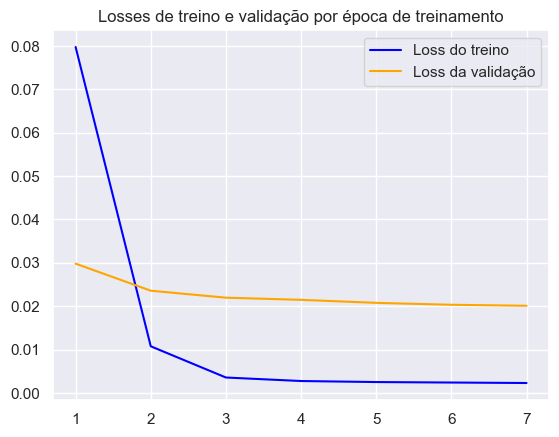

In [48]:
def plot_train_val_losses(train_avg_losses, val_avg_losses):
  epochs = list(range(1, len(train_avg_losses)+1))
  plt.plot(epochs, train_avg_losses, color='blue', label='Loss do treino')
  plt.plot(epochs, val_avg_losses, color='orange', label='Loss da validação')
  plt.title('Losses de treino e validação por época de treinamento')
  plt.legend()

plot_train_val_losses(train_avg_losses, val_avg_losses)

# Definindo um threshold e avaliando resultados

In [49]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [50]:
def get_tpr_per_attack(y_labels, y_pred):
  aux_df = pd.DataFrame({'Label':y_labels,'prediction':y_pred})
  total_per_label = aux_df['Label'].value_counts().to_dict()
  correct_predictions_per_label = aux_df.query('Label != "BENIGN" and prediction == True').groupby('Label').size().to_dict()
  tpr_per_attack = {}
  for attack_label, total in total_per_label.items():
    if attack_label == 'BENIGN':
      continue
    tp = correct_predictions_per_label[attack_label] if attack_label in correct_predictions_per_label else 0
    tpr = tp/total
    tpr_per_attack[attack_label] = tpr
  return tpr_per_attack

In [51]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [52]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

## Conjunto de validação

In [53]:
def get_autoencoder_anomaly_scores(ae_model, X):
  X = torch.FloatTensor(X)
  reconstructed_X = ae_model(X)
  anomaly_scores = torch.mean(torch.pow(X - reconstructed_X, 2), axis=1).detach().numpy() # MSELoss
  return anomaly_scores

In [54]:
val_anomaly_scores = get_autoencoder_anomaly_scores(ae_model, norm_X_val)

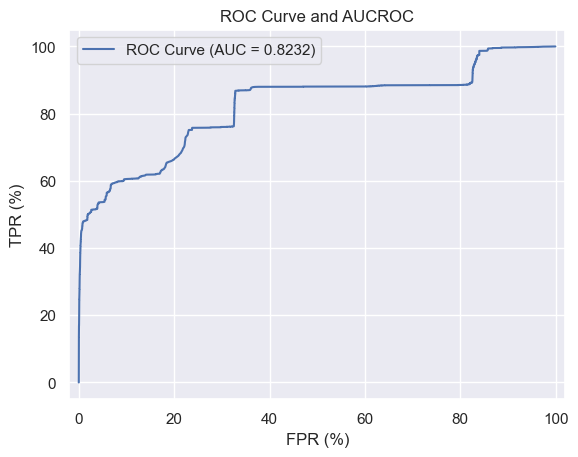

In [55]:
plot_roc_curve(y_val, val_anomaly_scores)

In [56]:
fpr, tpr, thresholds = roc_curve(y_val, val_anomaly_scores)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').query('fpr < 0.03')

,fpr,tpr,thresholds,youden-index
7591,0.026130,0.513773,0.017357,0.487644
7593,0.026140,0.513780,0.017348,0.487640
7595,0.026160,0.513793,0.017340,0.487633
7589,0.026116,0.513747,0.017374,0.487630
7597,0.026171,0.513800,0.017334,0.487630
...,...,...,...,...
16,0.000014,0.014303,0.080443,0.014290
12,0.000010,0.008581,0.084706,0.008570
10,0.000007,0.007829,0.085147,0.007822
8,0.000003,0.007527,0.085471,0.007524


In [57]:
BEST_VALIDATION_THRESHOLD = 0.018680

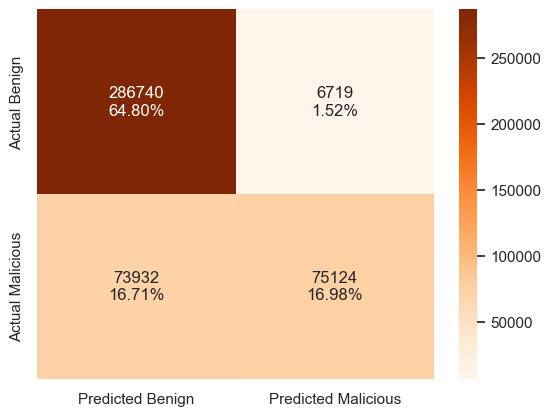

In [58]:
plot_confusion_matrix(y_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

In [59]:
get_overall_metrics(y_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'acc': 0.817744031275776,
 'tpr': 0.5039984972091026,
 'fpr': 0.02289587301803659,
 'precision': 0.9179037914054959,
 'f1-score': 0.650708751445437}

In [60]:
get_tpr_per_attack(classes_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'DoS Hulk': 0.8809673366834171,
 'DDoS': 0.43761996161228406,
 'PortScan': 0.0018561046968886652,
 'DoS GoldenEye': 0.3675,
 'FTP-Patator': 0.0004816955684007707,
 'DoS slowloris': 0.23660477453580903,
 'DoS Slowhttptest': 0.20546448087431693,
 'SSH-Patator': 0.0,
 'Bot': 0.016105417276720352,
 'Brute Force': 0.0,
 'XSS': 0.0,
 'Infiltration': 0.07692307692307693,
 'Sql Injection': 0.0,
 'Heartbleed': 1.0}

## Conjunto de teste

In [61]:
test_anomaly_scores = get_autoencoder_anomaly_scores(ae_model, norm_X_test)

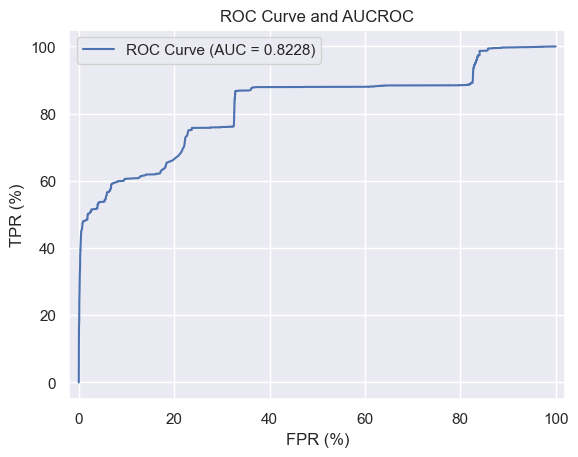

In [62]:
plot_roc_curve(y_test, test_anomaly_scores)

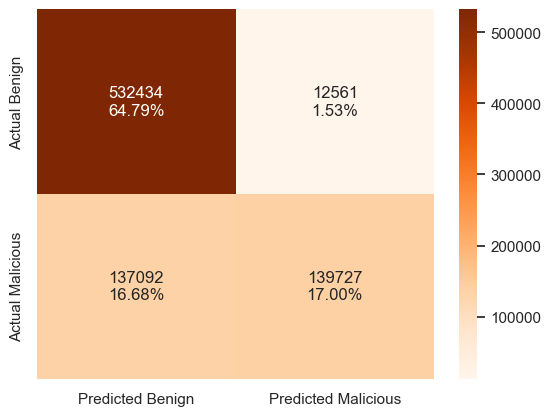

In [63]:
plot_confusion_matrix(y_test, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

In [64]:
get_overall_metrics(y_test, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'acc': 0.8178991840002726,
 'tpr': 0.5047594276404438,
 'fpr': 0.023047917870806154,
 'precision': 0.9175181235553688,
 'f1-score': 0.6512454935482292}

In [65]:
get_tpr_per_attack(classes_test, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'DoS Hulk': 0.8809968847352025,
 'DDoS': 0.44006729960341306,
 'PortScan': 0.002269955278493021,
 'DoS GoldenEye': 0.3798982949446605,
 'FTP-Patator': 0.00025926886180969663,
 'DoS slowloris': 0.22685714285714287,
 'DoS Slowhttptest': 0.1848145968216598,
 'SSH-Patator': 0.0,
 'Bot': 0.01889763779527559,
 'Brute Force': 0.0,
 'XSS': 0.0,
 'Infiltration': 0.043478260869565216,
 'Sql Injection': 0.0,
 'Heartbleed': 1.0}

# Pergunta e atividade

## Como um autoencoder é capaz de realizar detecção de anomalias?

#### Resposta:

Primeiramente, o modelo de autoencoder é treinado apenas com dados BENIGNOS, é como se o modelo fosse especializado em usar o autoencoder para recriar os dados benignos. Depois, quando o modelo for avaliado e/ou testado, ele processará dados também MALIGNOS desta vez. Dado um dado, quanto mais diferente a saída do modelo for da entrada, mais chance aquele dado tem de ser um dado MALIGNO, pelo fato do modelo ter sido especializado em reconstruir dados BENIGNOS, então se o modelo não está conseguindo reconstruir bem alguns dados, então talvez estes dados não sejam benignos. A partir de um treshold, o modelo vai decidir se o nível de diferença(loss) da saída comparada com a entrada é o suficiente para classificar um dado como benigno ou maligno.

# Atividade de código

Autoencoders podem ter diferentes arquiteturas de redes neurais para funcionar. O autoencoder visto acima possui as seguintes camadas (representadas juntamente com suas respectivas quantidades de neurônios):

*features de entrada -> 25 neurônios -> 10 neurônios -> 25 neurônios -> 10 neurônios*

**Crie você mesmo e avalie resultados de um autoencoder com uma nova arquitetura, considerando as seguintes camadas (representadas juntamente com suas respectivas quantidades de neurônios):**

**features de entrada -> 30 neurônios -> 20 neurônios -> 10 neurônios -> 20 neurônios -> 30 neurônios -> features de entrada**



OBS: Não é necessário tunar os hiperparâmetros

#### Avaliação dos Resultados:

A nova arquitetura apresenta uma loss bem menor durante a validação, porém, os resultados de AUC foram cerca de 7% menores do que a arquitetura antiga, em todas as curvas ROC.
| Loss - Validação | Modelo antigo | Modelo Novo |
|------------------|:-------------:|:-----------:|
| 1                |    ~0.075     |    ~0.03    |
| 2                |    ~0.028     |    ~0.024   |
| 3                |    ~0.025     |    ~0.022   |
---------------------
| AUC - Modelo antigo | AUC -  Modelo Novo |
|:-------------------:|:------------------:|
|         ~89%        |        ~82%        |

Na matriz de confusão da nova arquitetura, a quantidade de positivos foi maior do que no modelo antigo, enquanto a quantidade de negativos foi menor:

| Matriz de Confusão - Teste | Modelo antigo | Modelo Novo |
|----------------------------|:-------------:|:-----------:|
| Verdadeiro Positivo        |    65,90%     |   64.79%    |
| Falso Positivo             |    0.42%      |   1.53%     |
| Verdadeiro Negativo        |    16.09%     |   17%       |
| Falso Negativo             |    17.59%     |   16.68%    |

Eu ainda escolheria o modelo antigo, porque proporcionalmente falando, a quantidade de falsos positivos quase quadruplicou. Além disso, a loss na validação pode até ter uma grande diferença nas primeiras épocas, mas depois a diferença diminui bastante ao ponto de se tornar desprezível.